# CASE STUDY - performance monitoring (solution)

You will be building your own workflow template in this tutorial.  You already have a Dockerfile and a basic Flask application to build an API.  Lets combine what you have learned about logging to build a ``workflow-template`` that can be used to deploy models in a way that facilitates performance monitoring.

There are three main parts to this case study.

1. Write unit tests for a logger and a logging API endpoint
2. Add logging to your Docker container
3. Add an API endpoint for logging
4. Make sure all tests pass
5. Create model performance investigative tooling
6. Swap out the iris data for the AAVAIL churn data

You may want to eventually rename the directory because in this case-study you will swap out the iris data for `aavail-target.csv`.  It reality you will eventually want a library of workflow templates to work from and the naming convention you decide on can help with organization.  This notebook should reside in that source directory regardless of the name.  We suggest that you go through all of the tasks **first** using the iris data **then** copy the template to a new folder and make it work for the AAVAIL churn data.  Eventually you will want a suite of workflow templates that you will be able to select from.

In [20]:
import os
import sys
import csv
import requests
from collections import Counter
from datetime import date
from ast import literal_eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Getting started

The ``workflow-template.zip`` is a workflow template.  Unpack the directory in a location where you would like the source code to exist.  Leaving out the ``static`` directory that contains CSS and JavaScript to render a landing page, the important pieces are shown in the following tree.

```
├── app.py
├── Dockerfile
├── model.py
├── README.rst
├── requirements.txt
├── run-tests.py
├── templates
│   ├── base.html
│   ├── dashboard.html
│   ├── index.html
│   └── running.html
└── unittests
    ├── ApiTests.py
    ├── __init__.py
    ├── ModelTests.py
```

If you plan on modifying the HTML website you will need to modify the files in ``templates``.  The rest of the files you should be familiar with at this point.

We will be working with an Flask API to interact with our model. In order to access the different endpoints of this API make sure the app is running. Open a new command prompt and run the app with the command :


```
python path/to/working/directory/app.py -d
```

## TASK 1: Write units test for a logger

1. Using `model.py` and `./unittests/ModelTests.py` as an example complete `logger.py` and 
`./unittests/LoggerTests.py`.
2. Modify the files so that there are at a minimum the following tests:
 
    * ensure predict log is automatically created
    * ensure train log is automatically created
    * ensure that content can be retrieved from predict log file
    * ensure that content can be retrieved from train log file
    
> IMPORTANT: when writing to a log file from a unit test you will want to ensure that you do not modify or delete existing 'production' logs.  You can test your function with the following code (although it is likely easier to work directly in a terminal).

In [21]:
!python ./unittests/LoggerTests.py

....
----------------------------------------------------------------------
Ran 4 tests in 0.157s

OK


## TASK 2: Add an API endpoint for logging

In addition to the `predict` and `train` endpoints, create a third endpoint that returns 
logs.  Remember that there are `train` and `predict` log files and that they are set up 
to create new files each month.  You will need to ensure that your endpoint can accommodate this and the best way to ensure this is to **first write the unit tests** then write the code.

Flask has several functions to help with the sending of files. One example is [send_from_directory](https://flask.palletsprojects.com/en/1.1.x/api/#flask.send_from_directory).

In [22]:
# The API is ready we can test it. We invite you to take a close look into the ApiTests.py script.
!python ./unittests/ApiTests.py

....
----------------------------------------------------------------------
Ran 4 tests in 18.386s

OK


### SOLUTION NOTE

We can now access the logs through the API

In [23]:
r = requests.get('http://127.0.0.1:8080/logs/train-test.log')
print(r.text)

## TASK 3: Make sure all tests pass

You have been working on specific suites of unit tests.  It is a best practice to double-check that all tests pass after making major changes like the ones you have just completed.

> make sure you modify the `./unittests/__init__.py` so that the LoggerTest suite is also included when running all tests.

In [24]:
!python run-tests.py

... grid searching
... saving test version of model
... loading test version of model
... loading test version of model


..........C:\Users\abhishek buragohaibn\Anaconda3\envs\computervison\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
.
----------------------------------------------------------------------
Ran 11 tests in 38.161s

OK


## TASK 4: Create model performance investigative tooling

There are a lot of convenience functions you could create here.  Create them directly in this notebook or create them as scripts that you may call from this notebook.  

First write a script that accomplishes the following:

* train one model, then select another type of machine learning model and train again,  ensuring that each has separate version numbers.
* simulate a couple of hundred predictions for each model.

At minimum create a tablular summary and/or a simple plot that accomplishes the following:

1. Compare model performance for the two models
2. Determine if there was any drift from the first model to the second using a novelty detection algorithm.

In [25]:
! python run-model-train.py

... grid searching
... saving model: models\model-0_1.joblib
... saving latest data
model training complete.


In [26]:
## YOUR CODE HERE

from monitoring import get_latest_train_data, get_monitoring_tools

## load latest data
data = get_latest_train_data()
y = data['y']
X = data['X']

In [27]:
## generate some data
bs_samples = 60
subset_indices = np.random.choice(np.arange(X.shape[0]),
                                  bs_samples,replace=True).astype(int)
mask = np.in1d(np.arange(X.shape[0]), subset_indices)
X_bs=X[mask]
X_outliers = X[:5].copy()
X_outliers['age'] = [88, 90, 76, 80, 68]
X_outliers['num_streams'] = [111, 100, 80, 90, 150]
X_query = pd.concat([X_bs, X_outliers])

print(X_query.shape)

(63, 4)


In [ ]:
## delete the log file so we are starting fresh
today = date.today() 
logfile = os.path.join("logs", "predict-{}-{}.log".format(today.year, today.month)) 
print(logfile)
if os.path.exists(logfile):
    os.remove(logfile)

## ping the API
request_json = {'query':X_query.to_dict(), 'type':'dict'}
port = 8080
r = requests.post('http://127.0.0.1:{}/predict'.format(port), json=request_json)
response = literal_eval(r.text)
print(list(sorted(Counter(response['y_pred']).items())))

logs\predict-2021-4.log


In [ ]:
pm_tools = get_monitoring_tools(X, y)

In [ ]:
## read in the logged data
df = pd.read_csv(logfile)
df.drop(columns=["unique_id","y_proba"], inplace=True)
df.head()

In [17]:
## reconstruct a data frame from the logged queries
queries = [literal_eval(q) for q in df['query'].values]
queries = pd.DataFrame(queries)
queries.columns = [ 'age','country',  'num_streams', 'subscriber_type']
print(queries.shape)
queries.head()

(65, 4)


,age,country,num_streams,subscriber_type
0,88,united_states,111,aavail_premium
1,90,singapore,100,aavail_unlimited
2,48,united_states,23,aavail_unlimited
3,15,singapore,13,aavail_basic
4,21,singapore,10,aavail_unlimited


c:\users\abhishek buragohaibn\anaconda3\envs\computervison\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


OUTLIER TEST FAILED: 9.23 >= 2.1
DISTRIBUTION X TEST FAILED: 0.26 >= 0.02
DISTRIBUTION y TEST PASSED: 0 < 0.04


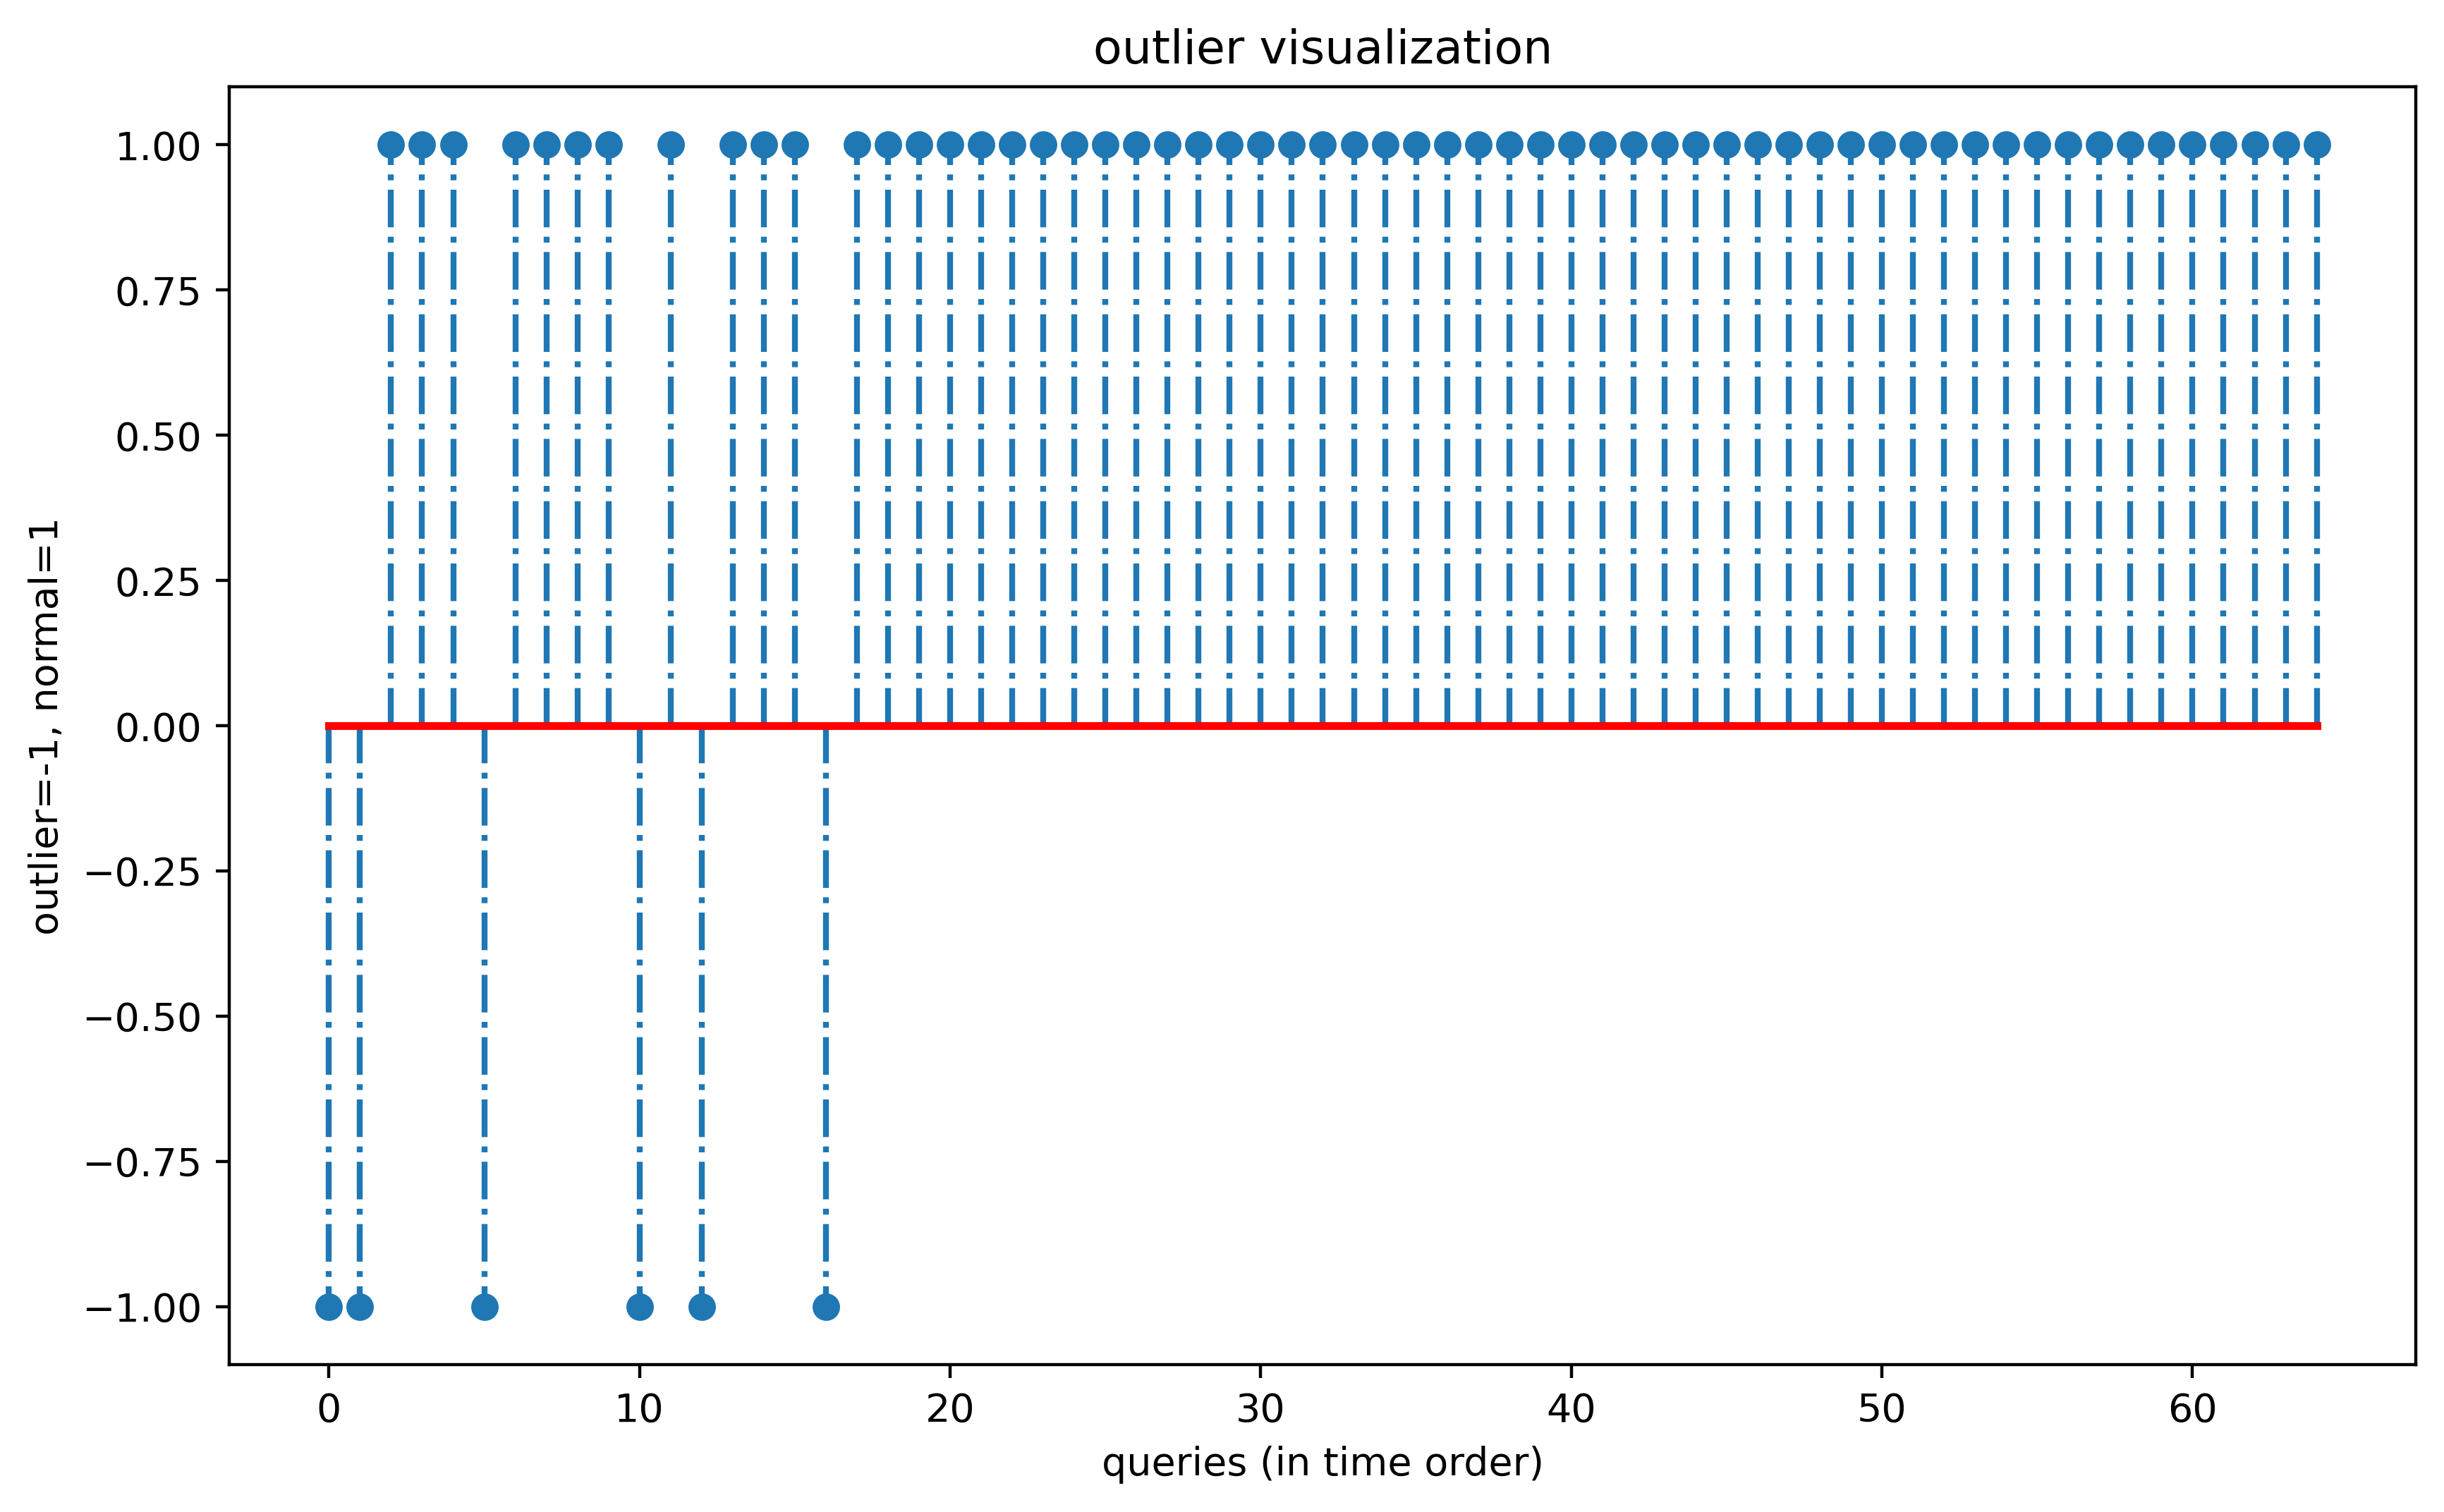

In [18]:
from scipy.stats import wasserstein_distance
X_target = pm_tools['preprocessor'].transform(queries)

outlier_test = pm_tools['clf_X'].predict(X_target)
outliers_X = 100 * (1.0 - (outlier_test[outlier_test==1].size / outlier_test.size))
wasserstein_X = wasserstein_distance(pm_tools['X_source'].flatten(), X_target.flatten()) 
wasserstein_y = wasserstein_distance(pm_tools['y_source'], df['y_pred'].values)

if outliers_X >= pm_tools['outlier_X']:
    print("OUTLIER TEST FAILED: {} >= {}".format(round(outliers_X,2),
                                                 pm_tools['outlier_X']))
else:
    print("OUTLIER TEST PASSED: {} < {}".format(round(outliers_X,2),
                                                pm_tools['outlier_X']))
    
if wasserstein_X >= pm_tools['wasserstein_X']:
    print("DISTRIBUTION X TEST FAILED: {} >= {}".format(round(wasserstein_X,2),
                                                        pm_tools['wasserstein_X']))
else:
    print("DISTRIBUTION X TEST PASSED: {} < {}".format(round(wasserstein_X),
                                                       pm_tools['wasserstein_X']))
    
if wasserstein_y >= pm_tools['wasserstein_y']:
    print("DISTRIBUTION y TEST FAILED: {} >= {}".format(round(wasserstein_y,2),
                                                        pm_tools['wasserstein_y']))
else:
    print("DISTRIBUTION y TEST PASSED: {} < {}".format(round(wasserstein_y),
                                                       pm_tools['wasserstein_y']))

fig = plt.figure(figsize=(10,6),dpi=400)
ax = fig.add_subplot(111)

x_range = np.arange(outlier_test.size)
labels = ['outlier','normal']
markerline, stemlines, baseline = ax.stem(x_range, outlier_test, '-.',
                                          use_line_collection=True)
plt.setp(baseline, 'color', 'r', 'linewidth', 2)
ax.set_title("outlier visualization")
ax.set_ylabel("outlier=-1, normal=1")
ax.set_xlabel("queries (in time order)");

### SOLUTION NOTE

The tests we choose to run are reasonable given the size of the data.  We are saving each query and with the reconstructed queries we can test for both outliers and distributional changes in the data.  All of this code would be better organized under `monitoring.py` in a production environment, but we walked through the process here with the hope that it provides some insight.  Be cautioned that the bootstrap and disk read/write portions of this code will take much longer with large data sets and some optimization will be required.  For example, you could pre-train and serialize the outlier model(s).

## TASK 5: Swap out the iris data for the AAVAIL churn data

We suggest that you copy the iris example folder to a another directory, then re-create the template to work with the AAVAIL data.  The exercise of changing the dataset is very much aligned with real-world practices since you will often be modifying workflow-templates to meet the needs of a particular business opportunity.

Start by updating the model.py script to load the AAVAIL data, apply an appropriate preprocessing pipeline to this data and fit a classifier. Then, run the tests. Looking at the output of the test adapt the different scripts until all the tests pass.

In [19]:
!python run-tests.py

... grid searching
... saving test version of model
... loading test version of model
... loading test version of model


..........C:\Users\abhishek buragohaibn\Anaconda3\envs\computervison\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
.
----------------------------------------------------------------------
Ran 11 tests in 37.392s

OK


In [ ]:
## this solution uses the AAVAIL data